<a href="https://colab.research.google.com/github/mehrdadkazemi254/Nonlinear_Optimization/blob/main/Branch%26Bound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Post Office needs a different number of fulltime postmen and postwomen for
different days of the week. The number of fulltime postmen/women required per
day, which is calculated according to the number of items to be delivered, is
provided in the table below



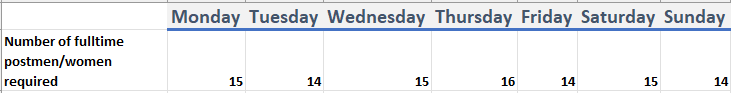

According to Trade Union rules, each fulltime employee has to work 5 days
running, and must then rest for 2 days. For instance, an employee who works
Monday–Friday must rest on Saturday and Sunday. The Post Office wishes to meet
its daily requirements and to use only fulltime employees.

(a) Formulate a mathematical model that the Post Office can use to obtain the
minimum number of fulltime postmen/women that it must work with.

(b) Calculate the two first tables of the Simplex Method that are required to obtain the solution to this problem.

Below we have implemented the branch and bound algorithm.

In [1]:
from scipy.optimize import linprog
import numpy as np
from math import floor, ceil
import copy
						
integer_var = [0,1,2,3,4,5,6]

c = [1]*7

A_ub = -np.array([[1,1,1,1,1,0,0],

       [0,1,1,1,1,1,0],

       [0,0,1,1,1,1,1],

       [1,0,0,1,1,1,1],

       [1,1,0,0,1,1,1],

       [1,1,1,0,0,1,1],

       [1,1,1,1,0,0,1]])

b_ub = -np.array([14, 15, 14, 15, 14, 15, 16])


# bounds for x0, x1 ...
#None means no constraint

x_bounds = []
x_bounds.append([0, None])
x_bounds.append([0, None])
x_bounds.append([0, None])
x_bounds.append([0, None])
x_bounds.append([0, None])
x_bounds.append([0, None])
x_bounds.append([0, None])



dangling_nodes = []
dangling_nodes_obj = []


class Node:
	def __init__(self, x_bounds=[], freeze_var_list=[], index=0, upper_or_lower=0):
		self._x_bounds = x_bounds
		self._freeze_var_list = freeze_var_list
		self._index = index
		self._upper_or_lower = upper_or_lower

		print("create Node:", index)
		print('')

	def freeze_var(self, index, val):
		self._x_bounds[index][0] = val
		self._x_bounds[index][1] = val
		self._freeze_var_list.append(index)

	def set_lp_res(self, res):
		self._res = res

		s = " "
		for l in range(len(self._res['x'])):
			if l in self._freeze_var_list:
				s += "[" + str(self._res['x'][l]) + "] "
			elif l in integer_var:
				s += "\'" + str(self._res['x'][l]) + "\' "
			else:
				s += str(self._res['x'][l])
		print("x: ", s)

	def check_integer_var_all_solved(self, m):
		return True if m == len(self._freeze_var_list) else False



def solve_LP(x_b):
	global c
	global A_ub
	global b_ub

	return linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_b)

def add_dangling_node(node):
	global z_star
	global dangling_nodes
	global dangling_nodes_obj
	global sol_node

	res = solve_LP(node._x_bounds)
	if check_feasibility(res) and res['fun'] < z_star:
		node.set_lp_res(res)
		dangling_nodes_obj.append(res['fun'])
		dangling_nodes.append(node)
		if node.check_integer_var_all_solved(len(integer_var)):
			z_star = res['fun']
			sol_node = node
			print("-----------Temporary sol-----------")
			print("x: ", sol_node._res['x'])
			print("z:", sol_node._res['fun'])
			print("-----------------------------------")
			print('')
		print("=> Add node to dangling list: ", node._index)
		print("=> current dangling nodes:", dangling_nodes_obj)
		print('')
		return True
	else:
		print("=> Node infeasibile: ", node._index)
		print("=> current dangling nodes:", dangling_nodes_obj)
		print('')
		return False

def del_higher_val_node(z_s):
	global dangling_nodes
	global dangling_nodes_obj
	
	del_list = []
	for i in range(len(dangling_nodes_obj)):
		if dangling_nodes_obj[i] >= z_s:
			del_list.append(i)

	s = ""
	for i in del_list:
		s += " " + str(dangling_nodes[i]._index)
		
	print("/***/ Remove nodes:", s)

	dangling_nodes = list(np.delete(dangling_nodes, del_list))
	dangling_nodes_obj = list(np.delete(dangling_nodes_obj, del_list))


	print("/***/ current dangling nodes: ", dangling_nodes_obj)
	print('')

def del_item(index):
	global dangling_nodes
	global dangling_nodes_obj

	print("/***/ Remove node: ", dangling_nodes[index]._index)

	dangling_nodes = list(np.delete(dangling_nodes, index))
	dangling_nodes_obj = list(np.delete(dangling_nodes_obj, index))
	print("/***/ current dangling nodes: ", dangling_nodes_obj)
	print('')

def check_feasibility(res):
	if res['status'] == 0:
		return True
	elif res['status'] == 2:
		return False
	else:
		raise("Problem Unbounded")
		exit()

def check_bounds(x_b, index, u_or_l):
	global x_bounds
	if u_or_l == 1:
		if x_b[index][0] is None and x_bounds[index][0] is not None:
			return False
		elif x_b[index][0] is not None and x_bounds[index][0] is None:
			return True
		elif x_b[index][0] is not None and x_bounds[index][0] is not None:
			return False if (x_b[index][0] < x_bounds[index][0]) else True 
	elif u_or_l == 2:
		if x_b[index][1] is None and x_bounds[index][1] is not None:
			return False
		elif x_b[index][1] is not None and x_bounds[index][1] is None:
			return True
		elif x_b[index][0] is not None and x_bounds[index][0] is not None:
			return False if (x_b[index][1] > x_bounds[index][1]) else True 
	else:
		print ("error of bounds")
		exit()
	


######################################################
print('')
print("######## Start B & B ###########")
print('')

z_star = float('Inf')
node_counter = 0
sol_node = None

node = Node(copy.deepcopy(x_bounds), [] ,node_counter)

node_counter += 1
res = solve_LP(x_bounds)

lower = floor(res['x'][integer_var[0]])
upper = lower + 1

lower_node = Node(copy.deepcopy(x_bounds), [], node_counter, 1)
lower_node.freeze_var(integer_var[0], lower)	
add_dangling_node(lower_node)

node_counter += 1

upper_node = Node(copy.deepcopy(x_bounds), [], node_counter, 2)
upper_node.freeze_var(integer_var[0], upper)
add_dangling_node(upper_node)

node_counter += 1

while len(dangling_nodes) > 0:

	index = np.argmin(dangling_nodes_obj)

	x_b  = dangling_nodes[index]._x_bounds
	frez = dangling_nodes[index]._freeze_var_list
	res = dangling_nodes[index]._res
	frez_var_index = len(frez)

	u_or_l = dangling_nodes[index]._upper_or_lower
	arbitrary_node = Node(copy.deepcopy(x_b), copy.deepcopy(frez), node_counter, copy.deepcopy(u_or_l))
	u_or_l_b = lower-1 if (u_or_l==1) else upper+1
	arbitrary_node.freeze_var(integer_var[frez_var_index - 1], u_or_l_b)
	x_b_arbi = arbitrary_node._x_bounds
	if check_bounds(x_b_arbi, integer_var[frez_var_index - 1], u_or_l):
		add_dangling_node(arbitrary_node)
	else:
		print("arbitrary Node infeasibile: ", arbitrary_node._index)
	
	node_counter += 1


	lower = floor(res['x'][integer_var[frez_var_index]])
	upper = lower + 1

	lower_node = Node(copy.deepcopy(x_b), copy.deepcopy(frez), node_counter, 1)
	lower_node.freeze_var(integer_var[frez_var_index], lower)	
	add_dangling_node(lower_node)

	node_counter += 1

	upper_node = Node(copy.deepcopy(x_b), copy.deepcopy(frez), node_counter, 2)
	upper_node.freeze_var(integer_var[frez_var_index], upper)
	add_dangling_node(upper_node)

	node_counter += 1

	del_item(index)
	del_higher_val_node(z_star)	
	print("#################################")

print('')
print("~~~~~~~~~~~~ Sol ~~~~~~~~~~~~~~")
print(sol_node._res)
print('')




######## Start B & B ###########

create Node: 0

create Node: 1

x:   [2.0] '4.189903385859075' '1.8100966141144887' '4.818539931215987' '1.1814600687583487' '3.416015227823831' '3.5839847721766054' 
=> Add node to dangling list:  1
=> current dangling nodes: [20.999999999948336]

create Node: 2

x:   [3.0] '3.666666664847525' '1.855548237606019' '4.811118428961231' '0.731799016418536' '3.9348676508481906' '2.666666667402357' 
=> Add node to dangling list:  2
=> current dangling nodes: [20.999999999948336, 20.66666666608386]

create Node: 3

x:   [4.0] '2.999999999997239' '2.392384998190411' '4.607615001794133' '0.7546401610859667' '4.245359838909204' '2.0000000000008615' 
=> Add node to dangling list:  3
=> current dangling nodes: [20.999999999948336, 20.66666666608386, 20.999999999977817]

create Node: 4

x:   [3.0] [3.0] '2.604475667908303' '4.395524332005952' '1.2513029050716713' '3.7486970949241387' '2.9999999999737827' 
=> Add node to dangling list:  4
=> current dangling nodes

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


=> Node infeasibile:  13
=> current dangling nodes: [20.999999999948336, 20.999999999977817, 20.999999999933372, 21.49999999999254, 20.999999999965816, 21.999999999990095, 22.00000000000037, 20.999999950074347, 21.999999999982563]

create Node: 14

x:   [3.0] [3.0] [2.0] [5.0] [1.0] '3.999999952464845' '2.99999998581416' 
=> Add node to dangling list:  14
=> current dangling nodes: [20.999999999948336, 20.999999999977817, 20.999999999933372, 21.49999999999254, 20.999999999965816, 21.999999999990095, 22.00000000000037, 20.999999950074347, 21.999999999982563, 20.999999938279004]

/***/ Remove node:  11
/***/ current dangling nodes:  [20.999999999948336, 20.999999999977817, 20.999999999933372, 21.49999999999254, 20.999999999965816, 21.999999999990095, 22.00000000000037, 21.999999999982563, 20.999999938279004]

/***/ Remove nodes: 
/***/ current dangling nodes:  [20.999999999948336, 20.999999999977817, 20.999999999933372, 21.49999999999254, 20.999999999965816, 21.999999999990095, 22.000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to 

In [2]:
for i, number in enumerate(sol_node._res.x):
  weekday = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thurday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

  print(f"Number of fulltime postmen/women who must start their 5-day shift on {weekday[i]} is {number.round()}")

print('\n')
print(f"In all, a minimum of  {sol_node._res.fun.round()} postmen/women are required.")

Number of fulltime postmen/women who must start their 5-day shift on Monday is 2.0
Number of fulltime postmen/women who must start their 5-day shift on Tuesday is 3.0
Number of fulltime postmen/women who must start their 5-day shift on Wednesday is 3.0
Number of fulltime postmen/women who must start their 5-day shift on Thurday is 4.0
Number of fulltime postmen/women who must start their 5-day shift on Friday is 2.0
Number of fulltime postmen/women who must start their 5-day shift on Saturday is 3.0
Number of fulltime postmen/women who must start their 5-day shift on Sunday is 4.0


In all, a minimum of  21.0 postmen/women are required.
